# 決定木

In [1]:
from sklearn.tree import DecisionTreeClassifier  # 決定木分類器
from sklearn.datasets import fetch_openml  # データセットのダウンロード取得用
import pandas as pd  # データフレーム操作用
import matplotlib.pyplot as plt  # グラフ描画用

In [2]:
# 1. データセットの取得
dataset = fetch_openml("pima-indians-diabetes", version=1, as_frame=True)  # Pimaデータセットを取得
# こんな感じのデータです．8変数の説明変数．Outcomeは0 or 1
dataset.frame.head()  # データフレームの最初の5行を表示

/opt/miniconda3/envs/avilen-ml/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# 1.1 参考までに相関行列を表示
corr = dataset.frame.corr()
# 相関行列をヒートマップで表示．有効数字2桁
corr.style.format(precision=2).background_gradient(cmap="coolwarm")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54,0.22
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26,0.47
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24,0.07
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11,0.07
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04,0.13
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04,0.29
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03,0.17
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00,0.24
Outcome,0.22,0.47,0.07,0.07,0.13,0.29,0.17,0.24,1.00


In [4]:
# 2. 説明変数をX，目的変数をyに分ける
X = dataset.data
y = dataset.target.astype("int")  # 目的変数は整数型に変換

# こっちの方が汎用性が高いです．PandasのDataFrameから変換する方法
df = dataset.frame
X = df.drop(columns=["Outcome"])  # Outcome列を除外
y = df["Outcome"].astype(int)  # Outcome列を抽出 & 整数型に変換

In [5]:
# 3. 訓練データとテストデータに分割
from sklearn.model_selection import train_test_split  # データ分割用
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=500)  # 80%訓練，20%テスト

In [6]:
# 4. 決定木を使って学習
#model = DecisionTreeClassifier()
#model = DecisionTreeClassifier(max_depth=3)  # 深さ3の決定木
model = DecisionTreeClassifier(criterion="gini", ccp_alpha=0.0)
model.fit(X_train, y_train)  # 学習

DecisionTreeClassifier()

In [7]:
from sklearn.metrics import accuracy_score  # 精度評価用
# 4.1 （意味ないけど）訓練データでの精度を確認
y_train_pred = model.predict(X_train)  # 訓練データで予測
accuracy_train = accuracy_score(y_train, y_train_pred)  # 精度計算
print(f"Train accuracy: {accuracy_train:.3f}")  # 精度表示 ⇒ 枝刈りしてない場合1になります．

Train accuracy: 1.000


In [8]:
# 5. テストデータで予測
y_pred = model.predict(X_test)  # 予測
# 6. 精度を評価
accuracy = accuracy_score(y_test, y_pred)  # 精度計算
print(f"Accuracy: {accuracy:.3f}")  # 精度を表示(小数点以下3桁)

Accuracy: 0.675


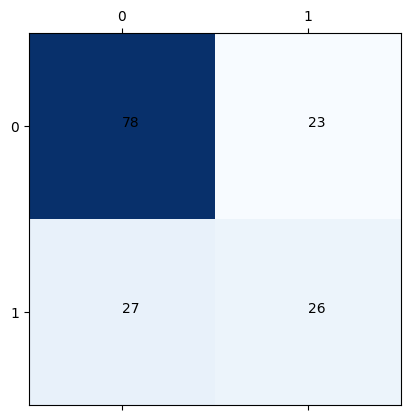

In [9]:
# 7. 混同行列を表示
from sklearn.metrics import confusion_matrix  # 混同行列用
cm = confusion_matrix(y_test, y_pred)  # 混同行列を計算
plt.matshow(cm, cmap="Blues")  # 混同行列をヒートマップで表示
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j])

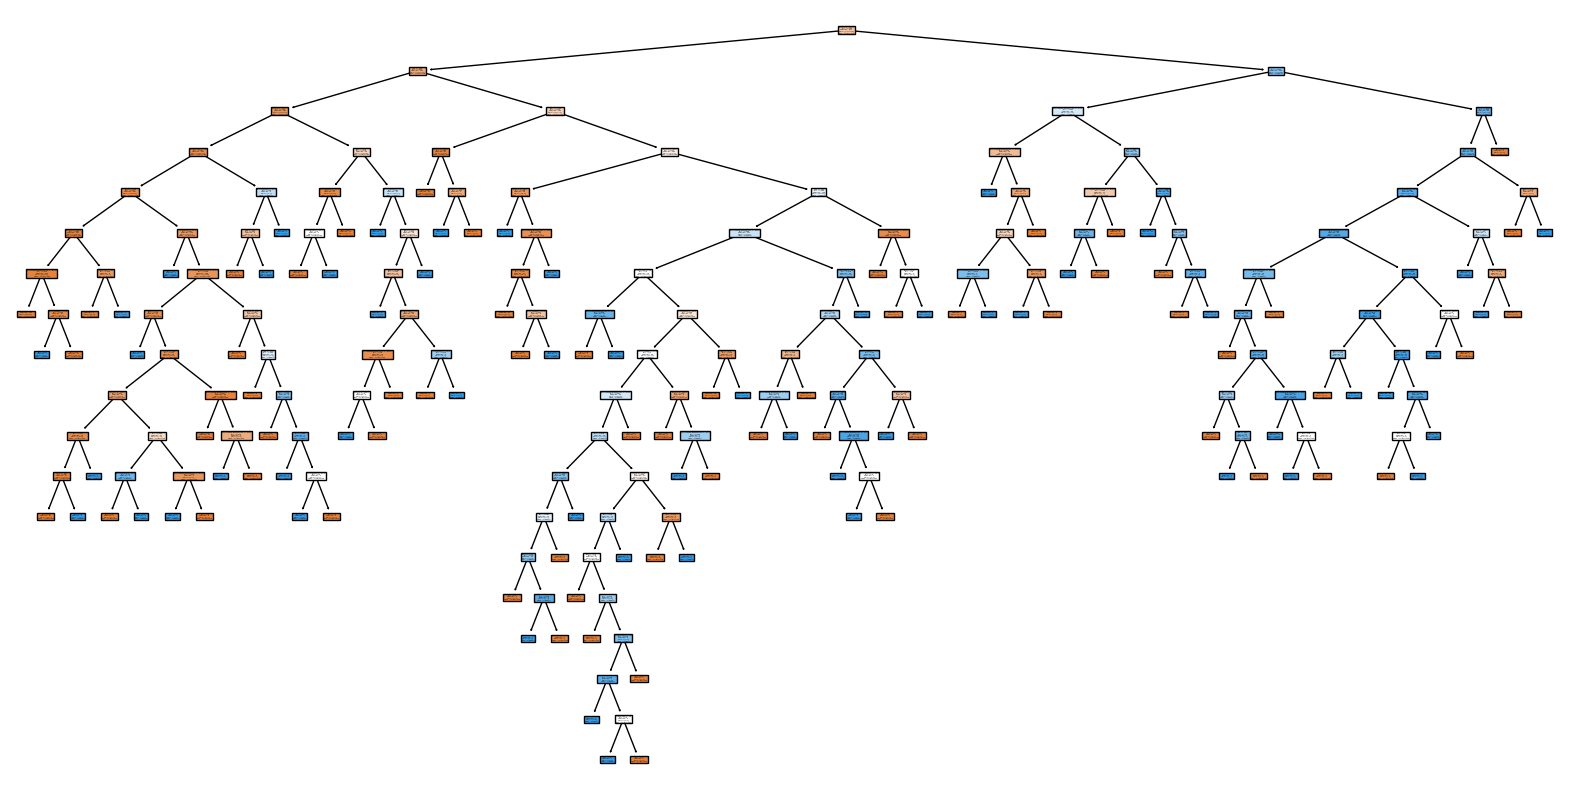

In [10]:
# 8. 決定木を表示
from sklearn.tree import plot_tree  # 決定木表示用
plt.figure(figsize=(20, 10))  # 図のサイズを指定
plot_tree(model, filled=True, feature_names=X.columns, class_names=["No Diabetes", "Diabetes"])  # 決定木を表示
plt.show()  # 図を表示


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

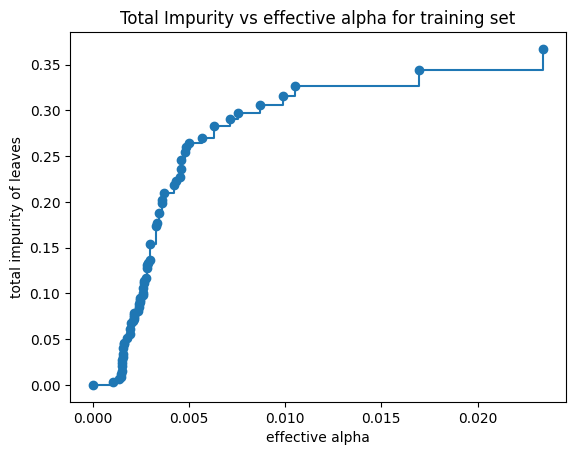

In [11]:
# 発展 : https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

# 9. 決定木の枝刈り
path = model.cost_complexity_pruning_path(X_train, y_train)  # 枝刈りのコスト複雑度を計算
ccp_alphas, impurities = path.ccp_alphas, path.impurities # α_effとジニ不純度

# α_effを使って枝刈りした場合のジニ不純度の変化を表示
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")


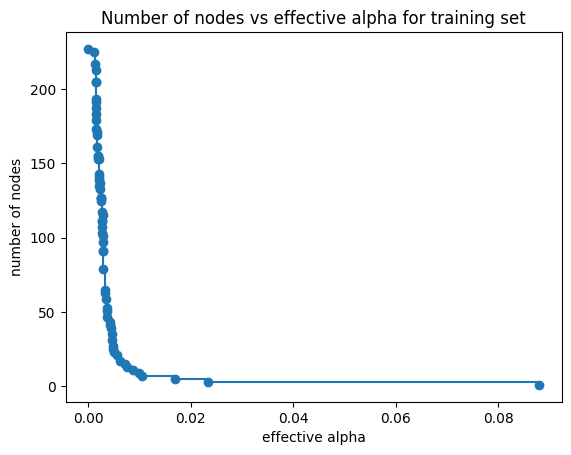

In [12]:
models = []
nodes = []
# いろんなccp_alphaを使って決定木を学習
for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    models.append(model)
    nodes.append(model.tree_.node_count)  # 各決定木のノード数を保存

# ノード数とccp_alphaの関係を表示
fig, ax = plt.subplots()
ax.plot(ccp_alphas, nodes, marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("number of nodes")
ax.set_title("Number of nodes vs effective alpha for training set")
plt.show()


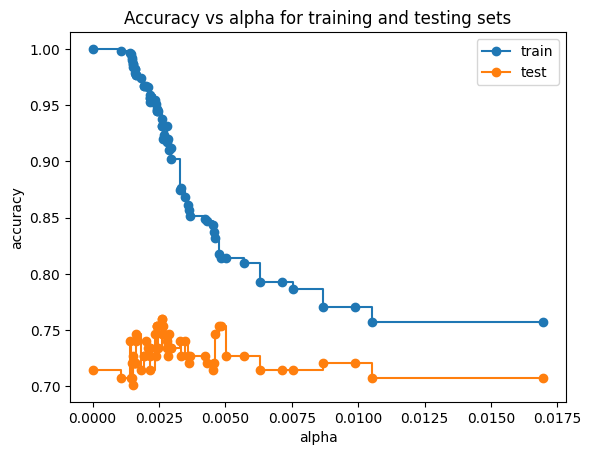

In [13]:
# 訓練データとテストデータでの精度を計算
train_scores = [model.score(X_train, y_train) for model in models]
test_scores = [model.score(X_test, y_test) for model in models]

# 横軸：ccp_alpha，縦軸：精度
# グラフを見やすくするために，ccp_alphaの最後の2つの値を表示から外してます
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[:-2], train_scores[:-2], marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[:-2], test_scores[:-2], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [14]:
# 注：X_testとy_testを使って，どのccp_alphaが最適かを選ぶのは，データリークになるので注意してください．
# 本来は，訓練用，検証用，テスト用の3つのデータセットを用意して，
# 訓練用データで学習，検証用データでccp_alphaを選び，テスト用データで最終的な精度を評価するのが正しいやり方です．
ccp_alpha = 0.0048
model = DecisionTreeClassifier(ccp_alpha=ccp_alpha)  # 決定木を学習
model.fit(X_train, y_train)  # 学習


DecisionTreeClassifier(ccp_alpha=0.0048)

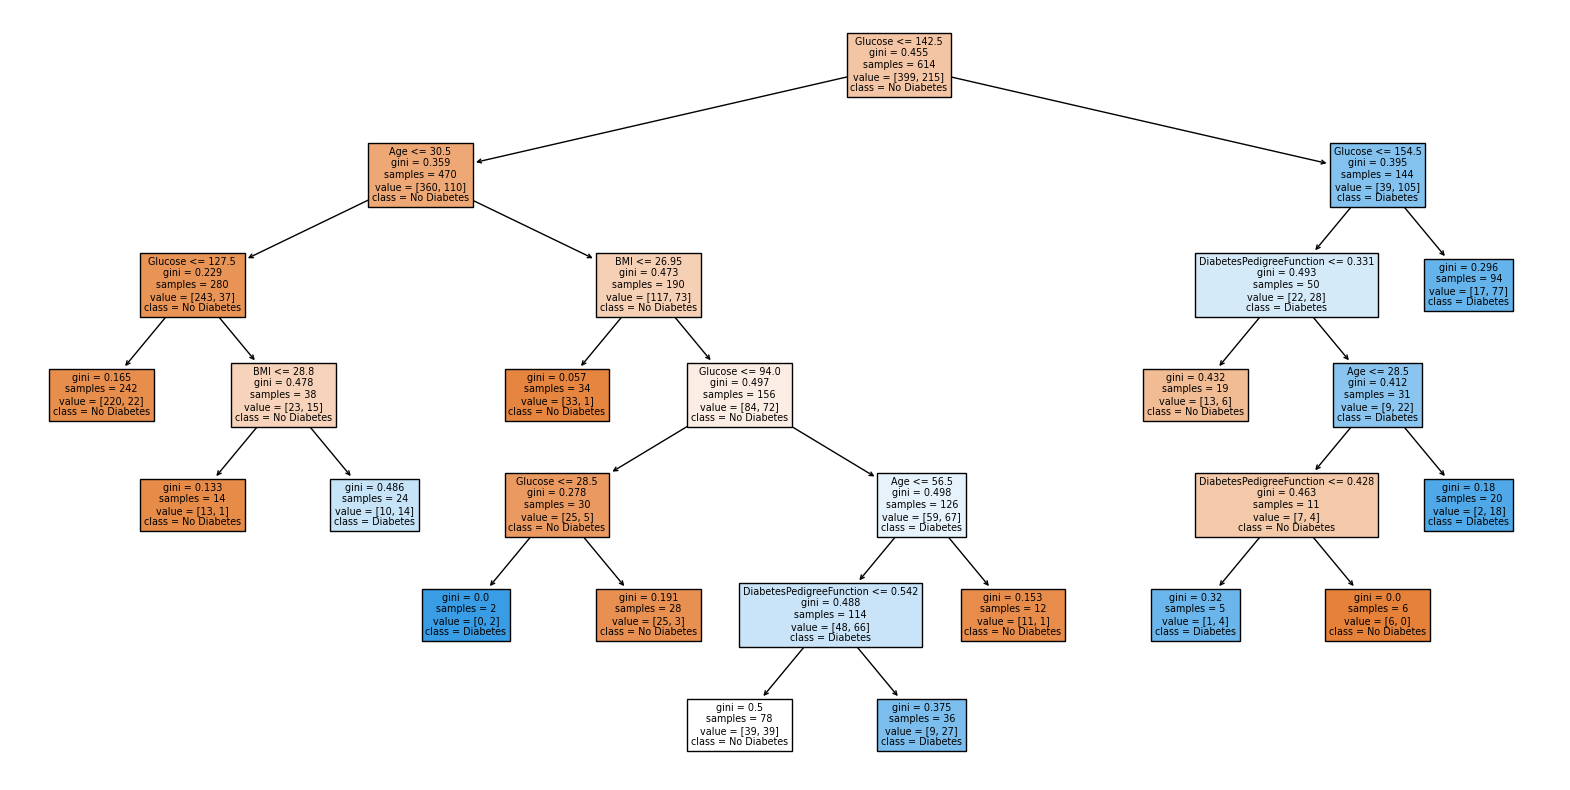

In [15]:
# 8. 決定木を表示
from sklearn.tree import plot_tree  # 決定木表示用
plt.figure(figsize=(20, 10))  # 図のサイズを指定
plot_tree(model, filled=True, feature_names=X.columns, class_names=["No Diabetes", "Diabetes"])  # 決定木を表示
plt.show()  # 図を表示